# Plant Seedlings Classification


Since the main problem the network encounters is distinguishing between Loose Silky-bent and Black-grass I decided to use another approach.
There are two models - one trained similarly as in previous notebooks.
The second one is trained only to distinguish between the two problematic classes.
For the final submission I will use the first one, but if it will say it's one of the two classes, I will switch to the second one.

This notebook is based on the 2nd version.

## 1. Setup



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# PATH = os.path.join('data', 'sample') + '/'
PATH = os.path.join('data')

### 1.1 Create second dataset

In [2]:
import os

In [3]:
def safe_mkdir(path):
    """
    Checks if a directory exists. If not, creates it.
    """
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        pass
    except AttributeError as exc:
        pass

In [4]:
PATH_2 = os.path.join('data_2')
safe_mkdir(PATH_2)

In [8]:
def copy_to_path_2(chosen_files, class_dir, data_type):
    for i in range (len(chosen_files)):
        !cp "{PATH}/{data_type}/{class_dir}/{chosen_files[i]}" "{PATH_2}/{data_type}/{class_dir}"

In [10]:
classes = ["Black-grass", "Loose Silky-bent"]
for classname in classes:
    for data_type in ["train", "valid"]:
        os.makedirs(f'{PATH_2}/{data_type}/{classname}', exist_ok=True)
        list_of_files = !ls "{PATH}/{data_type}/{classname}"
        copy_to_path_2(list_of_files, classname, data_type)

## 2. Creating the model

### 2.0 - initializing model

These are things we want to run before each section, so each time we start with a new network.

In [11]:
size = 128

In [12]:
arch=resnet34

In [13]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)

In [14]:
data_1 = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
model_1 = ConvLearner.pretrained(arch, data_1, precompute=False)

In [15]:
lrf=model_1.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▌| 57/60 [00:07<00:00,  7.69it/s, loss=38.6]


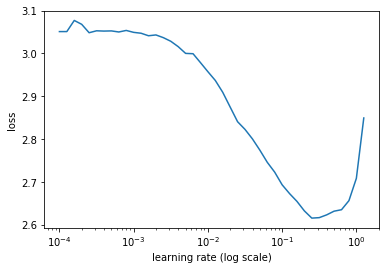

In [16]:
model_1.sched.plot()

The learning rate I decide to use is 2e-2

### 2.1 Learning model 1

In [17]:
model_1.fit(2e-2, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[0.      1.83656 1.30772 0.54185]                         
[1.      1.51778 1.06302 0.6231 ]                         
[2.      1.31497 0.9594  0.66869]                         
[3.      1.25316 0.96111 0.63015]                         
[4.      1.18987 0.88205 0.66661]                         
[5.      1.09447 0.84627 0.68952]                         
[6.      1.03788 0.83438 0.69732]                         
[7.      1.05592 0.84521 0.68092]                         
[8.      1.10454 0.82425 0.69551]                         
[9.      1.04633 0.78468 0.71869]                         
[10.       0.99015  0.77879  0.71661]                      
[11.       0.94775  0.75087  0.72911]                      
[12.       0.92456  0.72666  0.74628]                      
[13.       0.91606  0.72961  0.74238]                      
[14.       0.89131  0.73856  0.74238]                      
[15.       0.93608  0.75594  0.72469]                      
[16.       0.95254  0.7534   0.73327]             

This result gave much better result with the similar number of epochs.

In [18]:
model_1.save('cycles_512')

### 2.3 Finetuning

In [19]:
model_1.unfreeze()

In [20]:
learning_rate_base = 2e-2
lr=np.array([learning_rate_base/9,learning_rate_base/3,learning_rate_base])

In [21]:
model_1.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[0.      0.70501 0.42612 0.84187]                          
[1.      0.46747 0.33858 0.8807 ]                          
[2.      0.32873 0.28216 0.88772]                          
[3.      0.28987 0.36447 0.86691]                          
[4.      0.24875 0.28114 0.91117]                          
[5.      0.21216 0.25666 0.9104 ]                          
[6.      0.16314 0.24126 0.91951]                          
[7.      0.17791 0.2681  0.90206]                          
[8.      0.17562 0.30123 0.88956]                          
[9.      0.14794 0.25364 0.90441]                          
[10.       0.13203  0.24306  0.90466]                      
[11.       0.11407  0.19281  0.9328 ]                      
[12.       0.09592  0.1827   0.93462]                       
[13.       0.08237  0.20646  0.93045]                       
[14.       0.08015  0.20509  0.92316]                       



In [22]:
model_1.save('finetuning_412_div_3')

These results seem impressive - 93% accuracy on the validation set.

However, we may have experienced some overfitting - training loss dropped 2 times, while validation stayed pretty much te same.

Now we will try using different divisor for the finetuning

## 3. Training second network

### 3.0 - initializing model

In [44]:
size = 128

In [45]:
arch=resnet34

In [46]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)

In [47]:
data_2 = ImageClassifierData.from_paths(PATH_2, tfms=tfms)
model_2 = ConvLearner.pretrained(arch, data_2, precompute=False)

In [52]:
lrf=model_2.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[  0.        2.12189 109.1803    0.33488]                 



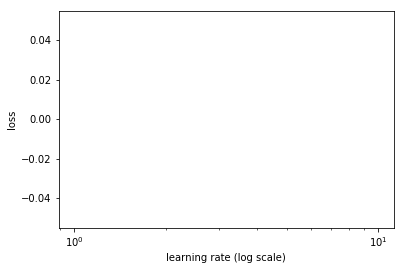

In [53]:
model_2.sched.plot()

### 3.1 Learning model 2

In [55]:
model_2.fit(1e-3, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[0.      0.66416 0.65756 0.63465]                          
[1.      0.6769  0.64372 0.65934]                          
[2.      0.67899 0.64032 0.65934]                          
[3.      0.67062 0.63635 0.67168]                          
[4.      0.66164 0.61178 0.69444]                          
[5.      0.66048 0.61402 0.69444]                          
[6.      0.65876 0.61751 0.69965]                          
[7.      0.64594 0.60685 0.72666]                          
[8.      0.63438 0.59471 0.73187]                          
[9.      0.62504 0.57794 0.73804]                          
[10.       0.61923  0.57703  0.74325]                      
[11.       0.61168  0.57433  0.73804]                      
[12.       0.60066  0.57628  0.73804]                      
[13.       0.59631  0.57428  0.74325]                      
[14.       0.59515  0.57283  0.73804]                      
[15.       0.59406  0.56749  0.73901]                      
[16.       0.58823  0.56517  0.73283]   

This result gave much better result with the similar number of epochs.

In [56]:
model_2.save('model_2_cycles_512')

### 2.3 Finetuning

In [57]:
model_2.unfreeze()

In [58]:
learning_rate_base = 1e-3
lr=np.array([learning_rate_base/9,learning_rate_base/3,learning_rate_base])

In [59]:
model_2.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[0.      0.64541 0.55519 0.73804]                          
[1.      0.61233 0.58268 0.72242]                          
[2.      0.6017  0.58342 0.71624]                          
[3.      0.59476 0.58485 0.72145]                          
[4.      0.58273 0.59051 0.72145]                          
[5.      0.57239 0.58484 0.72762]                          
[6.      0.55978 0.58572 0.72762]                          
[7.      0.5562  0.57995 0.73804]                          
[8.      0.55292 0.57246 0.74421]                          
[9.      0.55579 0.56713 0.73901]                          
[10.       0.5514   0.56503  0.75367]                      
[11.       0.54789  0.57047  0.7338 ]                      
[12.       0.53539  0.57114  0.73804]                      
[13.       0.53513  0.57111  0.72338]                      
[14.       0.53642  0.57474  0.71103]                      



In [60]:
model_2.save('model_2_finetuning_412_div_3')

## 3. Analysing the results

[[ 33   0   0   0   1   0  18   0   0   0   0   0]
 [  0  78   0   0   0   0   0   0   0   0   0   0]
 [  0   0  55   0   0   0   0   0   2   0   0   0]
 [  0   0   0 120   0   0   0   0   1   1   0   0]
 [  0   0   0   0  43   0   0   0   0   0   0   1]
 [  0   0   0   0   0  95   0   0   0   0   0   0]
 [ 16   0   0   0   0   0 113   0   1   0   0   0]
 [  0   0   0   0   0   0   0  44   0   0   0   0]
 [  0   0   0   1   0   0   0   0 102   0   0   0]
 [  0   0   0   1   0   0   0   0   3  42   0   0]
 [  0   1   0   0   0   0   0   0   0   0  98   0]
 [  0   0   0   0   0   0   0   0   0   0   0  77]]


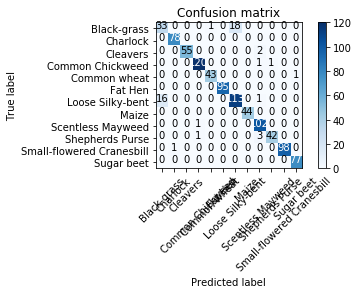

In [68]:
log_preds,y = model_1.TTA()
preds = np.argmax(log_preds, axis=1)
probs = np.mean(np.exp(log_preds), axis=0)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data_1.classes)

[[ 18  34]                                   
 [ 11 119]]


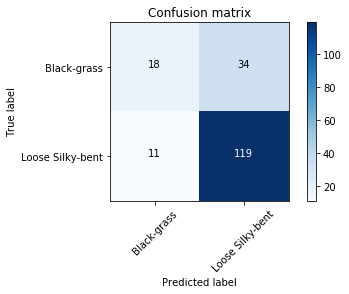

In [69]:
log_preds,y = model_2.TTA()
preds = np.argmax(log_preds, axis=1)
probs = np.mean(np.exp(log_preds), axis=0)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data_2.classes)

After comparing these two confusion matrices, we see that our network train specifically for disntinguishing Black-grass and Loose Silky-bent actually works worse than our initial network.

In [11]:
visualization_size = 4

In [12]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.amax(np.exp(log_preds),axis=1)

In [13]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], visualization_size, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [14]:
incorrect_ids = np.where((preds == data.val_y)==False)[0]

In [15]:
predictions = [preds[x] for x in incorrect_ids]

In [16]:
labels = [data.val_y[x] for x in incorrect_ids]

In [17]:
imgs = [load_img_id(data.val_ds, x) for x in incorrect_ids]

Predicted: Loose Silky-bent Real: Black-grass


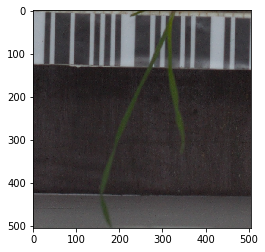

In [33]:
current_id = 0
plt.imshow(imgs[current_id])
print("Predicted:", data.classes[predictions[current_id]], "Real:", data.classes[labels[current_id]])

## 4. Conclusion

In [13]:
test_log_predictions, _ = learn.TTA(is_test=True)
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
test_file_names = learn.data.test_ds.fnames

with open('submission_2.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, test_predictions_classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission_2.csv')


/home/paperspace/kaggle_plant_seedlings/submission_2.csv

For now I will finish this experiment.
Ther results are pretty good, most of the mistakes are done due to confusing two classes, which I can't distinguish with my naked eye anyway.

After submitting this results to the competition I scored 0.95969 on the testing set, which placed me on the 209th position on the leaderboard, which at the moment of writing is top 40%.
Getting to this position took me about 6 hours of coding.

UPDATE:
I've re ran this experiment this time with 5 epochs instead of 4.
The results are much better: 
[30.       0.02685  0.17394  0.9453 ]                       
This scored 0.97355 on the Kaggle competition, which gave me 158th position (out of 581).